In [1]:
import pandas as pd
import gzip
import os
import numpy as np
from dtaidistance import dtw
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean

In [2]:
####################################################
############# Setear segun cada maquina ############
#os.chdir("C:/Users/herna/labo3_empresa3_repo/datasets")
#os.chdir("C:/diego_tools/labo3/dataset")
ruta_dataset = "/home/lumamdq/buckets/b1/datasets/"
####################################################

In [3]:
from datetime import datetime, timedelta
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Fecha en formato string
date_target = '2019-04-01'
resta = 20

# Convertir la fecha a un objeto datetime
date_target_obj = datetime.strptime(date_target, '%Y-%m-%d')

# Calcular date_to_split (dos meses antes)
date_target_mas2 = (date_target_obj - timedelta(days=1)).replace(day=1) - relativedelta(months=-3)

# Calcular date_tn_menos_uno (un mes antes)
date_tn_menos_seis= (date_target_obj - timedelta(days=1)).replace(day=1) - relativedelta(months=6)

date_target_mas2 = date_target_mas2.strftime('%Y-%m-%d')
date_tn_menos_seis = date_tn_menos_seis.strftime('%Y-%m-%d')
# Imprimir resultados
print("date_target_mas2:", date_target_mas2)
print("date_target:", date_target)
print("date_tn_menos_seis:", date_tn_menos_seis)

date_target_mas2: 2019-06-01
date_target: 2019-04-01
date_tn_menos_seis: 2018-09-01


In [4]:
arch_prod_ids_prediccion = ruta_dataset+"productos_a_predecir.csv"
arch_base = ruta_dataset+"emp3_sellout_base.csv"

In [5]:
#################################
###### Variables Generales ######
num_lags = 5

In [6]:
df = pd.read_csv(arch_base)

**tomo seis meses de historia para analizar los comportamientos de ventas**

In [7]:
date_tn_menos_seis = datetime.strptime(date_tn_menos_seis, '%Y-%m-%d')
date_tn_menos_seis = int(date_tn_menos_seis.strftime('%Y%m'))
df = df[df['periodo'] >= date_tn_menos_seis]
df.head(10)

,product_id,periodo,customer_id,cero_ventas,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,periodo_fecha,mes,...,cat3,brand,sku_size,producto_estrella,temp_media,temp_max_media,temp_min_media,IPC,promedio_mens_dolar_venta,catastrofe
20,20001,201809,10001,0,0.0,54.0,358.57922,358.57922,2018-09-01,9,...,Liquido,ARIEL,3000.0,1.0,17.4,21.5,13.8,6.5,38.53,False
21,20001,201810,10001,0,0.0,22.0,248.17132,245.21397,2018-10-01,10,...,Liquido,ARIEL,3000.0,1.0,18.0,22.4,13.2,5.4,37.06,False
22,20001,201811,10001,0,0.0,19.0,246.93909,241.02438,2018-11-01,11,...,Liquido,ARIEL,3000.0,1.0,21.6,26.3,16.7,3.2,36.48,False
23,20001,201812,10001,0,0.0,20.0,254.62373,254.62373,2018-12-01,12,...,Liquido,ARIEL,3000.0,1.0,22.6,27.4,17.6,2.6,37.83,False
24,20001,201901,10001,0,0.0,53.0,393.26092,386.60688,2019-01-01,1,...,Liquido,ARIEL,3000.0,1.0,24.9,29.3,20.7,2.9,37.39,False
25,20001,201902,10001,0,0.0,39.0,309.90610,309.90610,2019-02-01,2,...,Liquido,ARIEL,3000.0,1.0,24.2,29.1,19.2,3.8,38.40,False
26,20001,201903,10001,0,0.0,23.0,142.87158,130.54927,2019-03-01,3,...,Liquido,ARIEL,3000.0,1.0,21.0,25.6,16.8,4.7,41.52,False
27,20001,201904,10001,0,0.0,33.0,364.37071,364.37071,2019-04-01,4,...,Liquido,ARIEL,3000.0,1.0,19.3,24.3,15.0,3.4,43.26,False
28,20001,201905,10001,0,0.0,31.0,439.90647,439.90647,2019-05-01,5,...,Liquido,ARIEL,3000.0,1.0,15.8,20.1,12.0,3.1,44.88,False
29,20001,201906,10001,0,0.0,7.0,65.92436,65.92436,2019-06-01,6,...,Liquido,ARIEL,3000.0,1.0,14.5,17.8,11.3,2.7,43.73,False


**solo dejo los productos a precedir**

In [8]:
df_prods_prediccion=pd.read_csv(arch_prod_ids_prediccion)
df_prods_prediccion.head()

,product_id
0,20480
1,20481
2,20482
3,20483
4,20484


In [9]:
df = df[(df.product_id.isin(df_prods_prediccion.product_id))]

**genero 6 lags, que sera la serie de tiempo a analizar para clustering**

In [10]:
# Seleccionar las columnas 'periodo', 'product_id', 'customer_id' y 'tn'
df = df[['periodo', 'product_id', 'customer_id', 'tn']]
df.head()

,periodo,product_id,customer_id,tn
20,201809,20001,10001,358.57922
21,201810,20001,10001,245.21397
22,201811,20001,10001,241.02438
23,201812,20001,10001,254.62373
24,201901,20001,10001,386.60688


In [11]:
# Lags para product_id
for i in range(1, num_lags + 1):
    df[f'tn_lag_{i}'] = df.groupby(['product_id', 'customer_id'])['tn'].shift(i)

In [12]:
date_target_mas2 = datetime.strptime(date_target_mas2, '%Y-%m-%d')
date_target_mas2 = int(date_target_mas2.strftime('%Y%m'))
df = df[df['periodo'] == date_target_mas2]

In [13]:
# Columnas a llenar con ceros
cols_to_fill = ['tn', 'tn_lag_1', 'tn_lag_2', 'tn_lag_3', 'tn_lag_4', 'tn_lag_5']
df[cols_to_fill] = df[cols_to_fill].fillna(0)
df.head()

,periodo,product_id,customer_id,tn,tn_lag_1,tn_lag_2,tn_lag_3,tn_lag_4,tn_lag_5
29,201906,20001,10001,65.92436,439.90647,364.37071,130.54927,309.90610,386.60688
65,201906,20001,10002,144.07021,30.87299,55.41679,31.97079,6.48602,9.77943
101,201906,20001,10003,0.00000,1.84835,230.00152,170.89924,81.21522,180.51064
137,201906,20001,10004,66.71971,389.02653,91.67799,102.64484,155.26111,70.23717
173,201906,20001,10005,0.00000,15.89578,22.18016,6.90049,4.55925,6.53082


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498232 entries, 29 to 19166805
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   periodo      498232 non-null  int64  
 1   product_id   498232 non-null  int64  
 2   customer_id  498232 non-null  int64  
 3   tn           498232 non-null  float64
 4   tn_lag_1     498232 non-null  float64
 5   tn_lag_2     498232 non-null  float64
 6   tn_lag_3     498232 non-null  float64
 7   tn_lag_4     498232 non-null  float64
 8   tn_lag_5     498232 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 38.0 MB


**tomo las distancias de todos los registros para despues aplicar clustering**

In [15]:
# Crear campo serie_cero para excluirlos del analisis
df['serie_cero'] = 'N'
mask = (df[['tn', 'tn_lag_1', 'tn_lag_2', 'tn_lag_3', 'tn_lag_4', 'tn_lag_5']] == 0).all(axis=1)
df.loc[mask, 'serie_cero'] = 'Y'

In [16]:
#solo me quedo con aquellas series distintas a todo cero
df_serie = df[df['serie_cero'] == 'N']
# Suponiendo que tu DataFrame se llama 'df'
columns_to_convert = ['tn', 'tn_lag_1', 'tn_lag_2', 'tn_lag_3', 'tn_lag_4', 'tn_lag_5']
# Convertir las columnas seleccionadas a enteros
#df_serie[columns_to_convert] = df_serie[columns_to_convert].astype('int16')
df_serie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184541 entries, 29 to 19161012
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   periodo      184541 non-null  int64  
 1   product_id   184541 non-null  int64  
 2   customer_id  184541 non-null  int64  
 3   tn           184541 non-null  float64
 4   tn_lag_1     184541 non-null  float64
 5   tn_lag_2     184541 non-null  float64
 6   tn_lag_3     184541 non-null  float64
 7   tn_lag_4     184541 non-null  float64
 8   tn_lag_5     184541 non-null  float64
 9   serie_cero   184541 non-null  object 
dtypes: float64(6), int64(3), object(1)
memory usage: 15.5+ MB


In [17]:
#busco un punto de corte para aquellos tn grandes
df_serie.describe()

,periodo,product_id,customer_id,tn,tn_lag_1,tn_lag_2,tn_lag_3,tn_lag_4,tn_lag_5
count,184541.0,184541.000000,184541.000000,184541.000000,184541.000000,184541.000000,184541.000000,184541.000000,184541.000000
mean,201906.0,20432.119822,10206.143562,0.169260,0.175654,0.182961,0.189829,0.166393,0.161557
std,0.0,310.152987,145.133685,1.804973,2.220467,2.083009,1.909864,1.767813,1.943064
min,201906.0,20001.000000,10001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,201906.0,20168.000000,10081.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,201906.0,20378.000000,10182.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,201906.0,20653.000000,10315.000000,0.018350,0.016220,0.019930,0.029740,0.025480,0.014560
max,201906.0,21271.000000,10604.000000,198.507840,439.906470,364.370710,243.242400,309.906100,386.606880


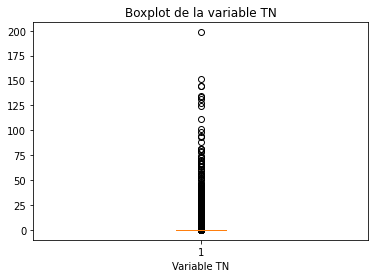

In [18]:
import matplotlib.pyplot as plt
# Graficar el boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(df_serie['tn'])
plt.title('Boxplot de la variable TN')
plt.xlabel('Variable TN')
plt.show()


In [19]:
# Valor de corte
cutoff_value = 0.4
# Contar cuántos valores son mayores que el corte
count_greater_than_cutoff = sum(1 for value in df_serie['tn'] if value > cutoff_value)
print(f"Registros mayores que {cutoff_value}: {count_greater_than_cutoff}")

Registros mayores que 0.4: 10247


In [20]:
df_serie = df_serie[df_serie['tn'] >= cutoff_value]
df_serie.describe()

,periodo,product_id,customer_id,tn,tn_lag_1,tn_lag_2,tn_lag_3,tn_lag_4,tn_lag_5
count,10247.0,10247.000000,10247.000000,10247.000000,10247.000000,10247.000000,10247.000000,10247.000000,10247.000000
mean,201906.0,20158.276081,10058.580755,2.673180,2.060767,2.115332,2.098814,1.874963,1.888938
std,0.0,168.594900,73.090587,7.209938,8.923447,7.978660,7.231430,6.940179,7.576448
min,201906.0,20001.000000,10001.000000,0.400380,0.000000,0.000000,0.000000,0.000000,0.000000
25%,201906.0,20037.000000,10009.000000,0.627105,0.000000,0.000000,0.000000,0.000000,0.000000
50%,201906.0,20096.000000,10030.000000,0.960960,0.436800,0.470860,0.546000,0.465330,0.386690
75%,201906.0,20227.000000,10078.500000,2.133140,1.505680,1.485265,1.572480,1.505710,1.488055
max,201906.0,21233.000000,10511.000000,198.507840,439.906470,364.370710,243.242400,309.906100,386.606880


In [21]:
df_serie.count()

periodo        10247
product_id     10247
customer_id    10247
tn             10247
tn_lag_1       10247
tn_lag_2       10247
tn_lag_3       10247
tn_lag_4       10247
tn_lag_5       10247
serie_cero     10247
dtype: int64

In [22]:
# Seleccionar las columnas relevantes
time_series_df = df_serie[['tn', 'tn_lag_1', 'tn_lag_2', 'tn_lag_3', 'tn_lag_4', 'tn_lag_5']]
# Obtener las series temporales
time_series_list = time_series_df.values.tolist()
len(time_series_list)

10247

In [23]:
# Función para calcular las distancias DTW
def calculate_dtw(series1, series2):
    distance = dtw.distance(series1, series2)
    return distance
print('comienzo')
# Calcular matriz de distancias DTW
n = len(time_series_list)

# Definir el número de divisiones
num_divisions = 10
division_size = n // num_divisions

# Lista para almacenar los DataFrames de las divisiones
dfs = []

# Iterar para generar las divisiones y guardarlas en archivos CSV
for i in range(num_divisions):
    start = i * division_size
    end = start + division_size if i < num_divisions - 1 else n

    division = np.zeros((end - start, n))
    
    for j in range(start, end):
        for k in range(n):
            division[j - start][k] = calculate_dtw(time_series_list[j], time_series_list[k])
            
            # Print cada 500 iteraciones
            if (j - start) % 100 == 0 and k == 0:
                print(f"Progreso - Iteración {i + 1}: {j - start}/{end - start}")

    df_division = pd.DataFrame(division)
    df_division.to_csv(ruta_dataset + f'division_{i}.csv', index=False)
    dfs.append(df_division)

# Concatenar todos los archivos CSV
final_df = pd.concat(dfs)
final_df.to_csv(ruta_dataset + 'final_distance_matrix.csv', index=False)

comienzo
Progreso - Iteración 1: 0/1024
Progreso - Iteración 1: 100/1024
Progreso - Iteración 1: 200/1024
Progreso - Iteración 1: 300/1024
Progreso - Iteración 1: 400/1024
Progreso - Iteración 1: 500/1024
Progreso - Iteración 1: 600/1024
Progreso - Iteración 1: 700/1024
Progreso - Iteración 1: 800/1024
Progreso - Iteración 1: 900/1024
Progreso - Iteración 1: 1000/1024
Progreso - Iteración 2: 0/1024
Progreso - Iteración 2: 100/1024
Progreso - Iteración 2: 200/1024
Progreso - Iteración 2: 300/1024
Progreso - Iteración 2: 400/1024
Progreso - Iteración 2: 500/1024
Progreso - Iteración 2: 600/1024
Progreso - Iteración 2: 700/1024
Progreso - Iteración 2: 800/1024
Progreso - Iteración 2: 900/1024
Progreso - Iteración 2: 1000/1024
Progreso - Iteración 3: 0/1024
Progreso - Iteración 3: 100/1024
Progreso - Iteración 3: 200/1024
Progreso - Iteración 3: 300/1024
Progreso - Iteración 3: 400/1024
Progreso - Iteración 3: 500/1024
Progreso - Iteración 3: 600/1024
Progreso - Iteración 3: 700/1024
Progr

In [24]:
#dataframe final con las distancias tomadas
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10247 entries, 0 to 1030
Columns: 10247 entries, 0 to 10246
dtypes: float64(10247)
memory usage: 801.2 MB


In [25]:
final_df.head()

,0,1,2,3,4,5,6,7,8,9,...,10237,10238,10239,10240,10241,10242,10243,10244,10245,10246
0,0.000000,633.655124,359.849705,648.658989,373.849643,604.569931,708.182468,583.169532,621.586955,545.901719,...,769.067024,769.223938,770.093842,769.912199,769.136030,769.953518,769.773459,770.108070,769.805103,770.139223
1,633.655124,0.000000,285.527208,98.928956,251.443603,114.618196,122.082303,139.977980,91.293133,95.156133,...,160.084829,159.499376,159.778817,160.308987,160.082509,159.600081,160.084887,160.463171,160.458602,160.681961
2,359.849705,285.527208,0.000000,305.573912,170.033834,270.031589,393.694852,305.083867,288.781797,260.827351,...,450.346462,450.605185,451.261137,451.119204,450.306112,451.132798,450.938291,451.294393,450.940561,451.342222
3,648.658989,98.928956,305.573912,0.000000,241.744243,44.386526,79.593968,89.334126,71.642306,127.068377,...,128.611013,127.750855,128.021831,128.581167,128.448225,127.840162,128.372644,128.744804,128.872261,129.056106
4,373.849643,251.443603,170.033834,241.744243,0.000000,203.887949,290.697784,191.816936,203.135024,156.430388,...,338.300161,338.374043,339.378362,339.213574,338.706988,339.020249,339.260855,339.408348,339.382311,339.527120


**buscar los mejores cluster KMeans**

/home/lumamdq/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/lumamdq/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/lumamdq/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/lumamdq/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/lumamdq/.local/lib/pyt

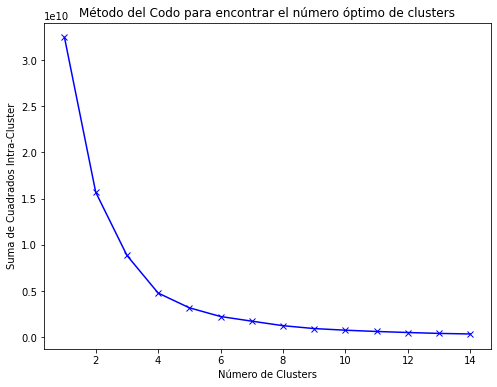

In [26]:
# Calcular la suma de cuadrados intra-cluster para diferentes valores de k
ssq = []
K = range(1, 15)  # Probamos hasta 10 clusters
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(final_df)
    ssq.append(kmeans.inertia_)

# Graficar la suma de cuadrados intra-cluster en función del número de clusters
plt.figure(figsize=(8, 6))
plt.plot(K, ssq, 'bx-')
plt.xlabel('Número de Clusters')
plt.ylabel('Suma de Cuadrados Intra-Cluster')
plt.title('Método del Codo para encontrar el número óptimo de clusters')
plt.show()

In [27]:
# Realizar clustering
k = 4  # Número de clusters deseado
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(final_df)

/home/lumamdq/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [28]:
df_serie['Cluster_dtw'] = clusters

In [29]:
df_serie.to_csv(ruta_dataset + 'dataset_clusterizado.csv', index=False)

In [30]:
df_serie.head()

,periodo,product_id,customer_id,tn,tn_lag_1,tn_lag_2,tn_lag_3,tn_lag_4,tn_lag_5,serie_cero,Cluster_dtw
29,201906,20001,10001,65.92436,439.90647,364.37071,130.54927,309.90610,386.60688,N,2
65,201906,20001,10002,144.07021,30.87299,55.41679,31.97079,6.48602,9.77943,N,1
137,201906,20001,10004,66.71971,389.02653,91.67799,102.64484,155.26111,70.23717,N,2
209,201906,20001,10006,61.02904,17.74413,107.20410,32.01560,3.55107,15.08923,N,1
245,201906,20001,10007,98.57848,80.58791,82.80592,243.24240,108.06666,146.51227,N,1


In [34]:
# Agrupar por 'Cluster_dtw' y sumar las columnas específicas
g1 = df_serie.groupby('Cluster_dtw')[['tn']].sum()
g2 = df_serie.groupby('Cluster_dtw')[['tn_lag_1']].sum()
g3 = df_serie.groupby('Cluster_dtw')[['tn_lag_2']].sum()
g4 = df_serie.groupby('Cluster_dtw')[['tn_lag_3']].sum()
g5 = df_serie.groupby('Cluster_dtw')[['tn_lag_4']].sum()
g6 = df_serie.groupby('Cluster_dtw')[['tn_lag_5']].sum()

planets.rename(columns={'periodo_orbital':'periodo orbital',
                        'método':'método descubrimiento'},
               index={0:'cero',1:'uno'},
               inplace=True)

In [35]:
pd.concat([g1, g2, g3, g4, g5], axis=0)

,tn,tn_lag_1,tn_lag_2,tn_lag_3,tn_lag_4
Cluster_dtw,,,,,
0,17452.59551,NaN,NaN,NaN,NaN
1,3027.46873,NaN,NaN,NaN,NaN
2,283.76488,NaN,NaN,NaN,NaN
3,6628.24363,NaN,NaN,NaN,NaN
0,NaN,11390.75233,NaN,NaN,NaN
1,NaN,2430.66761,NaN,NaN,NaN
2,NaN,1093.48649,NaN,NaN,NaN
3,NaN,6201.77481,NaN,NaN,NaN
0,NaN,NaN,11621.40476,NaN,NaN


In [ ]:
# Graficar la suma de las columnas para cada cluster
grouped.plot(kind='line', marker='o')  # Tipo de gráfico y estilo de marcador
plt.ylabel('Cluster_dtw')  # Etiqueta del eje x
plt.xlabel('Suma de valores')  # Etiqueta del eje y
plt.title('Suma de valores por Cluster_dtw')  # Título del gráfico
plt.legend(loc='upper right')  # Ubicación de la leyenda
plt.grid(True)  # Agregar cuadrícula al gráfico si es necesario

plt.show()  # Mostrar la gráfica